
<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; ">Analysez les ventes d'une librairie avec Python</h1>
</div>

In [1]:
# Modules
import numpy as np
import datetime
import pandas as pd


import statistics
import scipy.stats as stats
from scipy.stats import kstest,ttest_ind, spearmanr,chi2_contingency, mannwhitneyu,kruskal

import statsmodels.api as sm


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

L’entreprise Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. 

La structure a besoin d’aide pour mieux comprendre ses données, c’est pourquoi elle vous a recruté. Vous intervenez en tant que Data Analyst afin de faire le point sur l’activité. 

## Sommaire<a id='60'></a>


* [1. Importer et etudier/mesurer les fichiers mis à disposition](#10) 
    * [Customers](#11)
    * [Products](#12)
    * [Transactions](#13)

* [2. Correction des dataframes pour pouvoir les utiliser plus aisément](#20)

* [3. Analyse des données](#30)
    * [Moyenne mobile](#31)
    * [Détail du chiffre d'affaire](#32)
    * [Répartition des ventes](#33)
    * [Détail sur les nombre de transactions, clients, ventes par mensualités](#34)
    * [Zoom sur la chute des ventes](#35)
    * [Top et Flop](#36)
    * [Distribution des prix](#37)
    * [Zoom sur le profil client](#38)
    * [Courbe de Lorenz](#39)
    * [fréquentation sur le site](#40)
    * [Age des clients et panier moyen](#41)

* [4. Tests statistique](#50)
    * [Normalité de la distribution des prix et de l'âge](#51)
    * [Analyse des Proportions et Tests d’Indépendance entre le sexe et la catégorie](#52)
    * [Correlation en prix et sexe](#53)
    * [Tests de Variance et correlation entre prix et âge](#54)
    * [Comparaison de distribution entre sexe et prix](#55)
    * [Distribution des âges par catégorie](#56)
    * [Corrélation entre âge et panier moyen](#57)
    * [Fréquence d'achat par tranche d'âge](#58)

## 1. Importer et etudier/mesurer les fichiers mis à disposition<a id='10'></a>
[retourner au sommaire](#60)

Importation et lecture des types et format.

In [2]:
#Importation des données


df_customers=pd.read_csv("customers.csv",delimiter=';')
df_products=pd.read_csv("products.csv",delimiter=';')

df_transactions=pd.read_csv("transactions.csv",delimiter=';', low_memory=False) 
#pour df_transaction, les colonnes 0,1,2,3 on des types de données mixte.

### Customers<a id='11'></a>

In [3]:
#description des données.

print("Types de colonnes : ","\n",df_customers.dtypes)
print("\n\nCustomers comporte {} observation(s) ou article(s)".format(df_customers.shape[0]))
print("Ce tableau comporte {} colonne(s)".format(df_customers.shape[1]))
print("\n\n","Quelques lignes du tableau :","\n",df_customers.head())

Types de colonnes :  
 client_id    object
sex          object
birth         int64
dtype: object


Customers comporte 8621 observation(s) ou article(s)
Ce tableau comporte 3 colonne(s)


 Quelques lignes du tableau : 
   client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943


### Products<a id='12'></a>

In [4]:
print("Types de colonnes : ","\n",df_products.dtypes)
print("\n\nProducts comporte {} observation(s) ou article(s)".format(df_products.shape[0]))
print("Ce tableau comporte {} colonne(s)".format(df_products.shape[1]))
print("\n\n","Quelques lignes du tableau :","\n",df_products.head())

Types de colonnes :  
 id_prod     object
price      float64
categ        int64
dtype: object


Products comporte 3286 observation(s) ou article(s)
Ce tableau comporte 3 colonne(s)


 Quelques lignes du tableau : 
   id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0


In [5]:
df_products['price'].describe()

count    3286.000000
mean       21.863597
std        29.849786
min         0.620000
25%         6.990000
50%        13.075000
75%        22.990000
max       300.000000
Name: price, dtype: float64

### Transactions<a id='13'></a>

In [6]:
print("Types de colonnes : ","\n",df_transactions.dtypes)
print("\n\nTransactions comporte {} observation(s) ou article(s)".format(df_transactions.shape[0]))
print("Ce tableau comporte {} colonne(s)".format(df_transactions.shape[1]))
print("\n\n","Quelques lignes du tableau :","\n",df_transactions.head())

Types de colonnes :  
 id_prod       object
date          object
session_id    object
client_id     object
dtype: object


Transactions comporte 1048575 observation(s) ou article(s)
Ce tableau comporte 4 colonne(s)


 Quelques lignes du tableau : 
   id_prod                        date session_id client_id
0  0_1259  2021-03-01 00:01:07.843138        s_1     c_329
1  0_1390  2021-03-01 00:02:26.047414        s_2     c_664
2  0_1352  2021-03-01 00:02:38.311413        s_3     c_580
3  0_1458  2021-03-01 00:04:54.559692        s_4    c_7912
4  0_1358  2021-03-01 00:05:18.801198        s_5    c_2033


## 2. Correction des dataframes pour pouvoir les utiliser plus aisément.<a id='20'></a>
[retourner au sommaire](#60)

In [7]:
df_transactions['date']=pd.to_datetime(df_transactions['date']).dt.date

df_transactions['client_id'] = df_transactions['client_id'].astype(str)
df_transactions['client_id'] = df_transactions['client_id'].str[2:]
df_transactions['session_id'] = df_transactions['session_id'].str[2:]

df_transactions = df_transactions[df_transactions['client_id'].apply(lambda x: x.isdigit())]
df_transactions['client_id'] = df_transactions['client_id'].astype(int)
print("transformation du type de données dans divers colonnes.\n")
print(df_transactions.dtypes)
print("\n",df_transactions.head())

transformation du type de données dans divers colonnes.

id_prod       object
date          object
session_id    object
client_id      int32
dtype: object

   id_prod        date session_id  client_id
0  0_1259  2021-03-01          1        329
1  0_1390  2021-03-01          2        664
2  0_1352  2021-03-01          3        580
3  0_1458  2021-03-01          4       7912
4  0_1358  2021-03-01          5       2033


In [8]:

df_customers['client_id'] = df_customers['client_id'].astype(str)
df_customers['client_id'] = df_customers['client_id'].str[2:]
df_customers = df_customers[df_customers['client_id'].apply(lambda x: x.isdigit())]
df_customers['client_id'] = df_customers['client_id'].astype(int)

df_customers.head()

,client_id,sex,birth
0,4410,f,1967
1,7839,f,1975
2,1699,f,1984
3,5961,f,1962
4,5320,m,1943


In [9]:

print("Compte des nuls :\n")
alldf=['df_customers','df_products','df_transactions']
for i in alldf:
    print(f'{i} : {eval(i).isna().sum().sum()}')
del i

Compte des nuls :

df_customers : 0
df_products : 0
df_transactions : 0


In [10]:
print("Compte des valeurs négative \n")
for i, df in enumerate(alldf, 1):
    if isinstance(df, pd.DataFrame):
        # Conversion de chaque colonne en numérique (les valeurs non convertibles deviennent NaN)
        df_numeric = df.apply(pd.to_numeric, errors='coerce')
        
        # Affichage des valeurs négatives
        print(f"Valeurs négatives dans DataFrame {i}:")
        print(df_numeric[df_numeric < 0])
    else:
        print(f"L'objet à l'indice {i} n'a pas de valeurs négative.")
    print()  # Ligne vide pour plus de clarté

Compte des valeurs négative 

L'objet à l'indice 1 n'a pas de valeurs négative.

L'objet à l'indice 2 n'a pas de valeurs négative.

L'objet à l'indice 3 n'a pas de valeurs négative.



In [11]:

listcol=list(df_customers.columns)
print("Nom des colonnes dans Customers et date de naissance des clients :\n")
print(listcol)

print(df_customers['birth'].sort_values().unique())

Nom des colonnes dans Customers et date de naissance des clients :

['client_id', 'sex', 'birth']
[1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004]


In [12]:
print(df_products['price'].sort_values().head(10).tolist())
print("\n",df_products['price'].sort_values().tail(10).tolist())
print("\n",df_products['price'].mean())
count_row = df_products['price'].shape[0]
print(count_row)

[0.62, 0.62, 0.66, 0.77, 0.8, 0.81, 0.88, 0.92, 0.93, 0.97]

 [222.97, 225.17, 228.11, 230.04, 231.99, 233.54, 236.99, 247.22, 254.44, 300.0]

 21.86359707851491
3286


In [13]:
print("customer client_id duplicatas : ",df_customers['client_id'].duplicated().sum())
print("products id_prod duplicatas : ",df_products['id_prod'].duplicated().sum())

customer client_id duplicatas :  0
products id_prod duplicatas :  0


In [14]:
count_sex=df_customers['sex'].unique().tolist()
print("valeurs dans la colonne sex : ",count_sex)

valeurs dans la colonne sex :  ['f', 'm']


In [15]:
count_categ=df_products['categ'].unique().tolist()
print("valeurs dans la colonne categ : ",count_categ)

valeurs dans la colonne categ :  [0, 1, 2]


In [16]:
df_transactions.head()

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01,1,329
1,0_1390,2021-03-01,2,664
2,0_1352,2021-03-01,3,580
3,0_1458,2021-03-01,4,7912
4,0_1358,2021-03-01,5,2033


In [17]:
df_transactions['date']=pd.to_datetime(df_transactions['date'])
print(df_transactions.dtypes)
print(df_transactions.head(3))

id_prod               object
date          datetime64[ns]
session_id            object
client_id              int32
dtype: object
  id_prod       date session_id  client_id
0  0_1259 2021-03-01          1        329
1  0_1390 2021-03-01          2        664
2  0_1352 2021-03-01          3        580


In [18]:
df_transactions['date'].dt.year.value_counts().sort_index()

date
2021    286671
2022    346380
2023     54483
Name: count, dtype: int64

In [19]:
print("fusion des dataframes et compte des nuls :\n")

df = pd.merge((df_transactions), (df_products),
                    on=['id_prod'], how='left')

# Ajoute les informations clients
df = pd.merge((df), (df_customers),
                    on=['client_id'], how='left')

df = df[['client_id','sex','birth','id_prod','categ','price','session_id','date']]
print(df.head(10))
print('\n',df.isna().sum())

fusion des dataframes et compte des nuls :

   client_id sex  birth id_prod  categ  price session_id       date
0        329   f   1967  0_1259      0  11.99          1 2021-03-01
1        664   m   1960  0_1390      0  19.37          2 2021-03-01
2        580   m   1988  0_1352      0   4.50          3 2021-03-01
3       7912   f   1989  0_1458      0   6.55          4 2021-03-01
4       2033   f   1956  0_1358      0  16.49          5 2021-03-01
5       4908   f   1981  0_1073      0  13.99          6 2021-03-01
6       1609   m   1980  0_1304      0   5.86          7 2021-03-01
7       4908   f   1981   0_279      0  16.99          6 2021-03-01
8       7991   m   1968   1_445      1  23.99          8 2021-03-01
9       6171   m   1983   1_556      1  24.47          9 2021-03-01

 client_id     0
sex           0
birth         0
id_prod       0
categ         0
price         0
session_id    0
date          0
dtype: int64


In [20]:
df['age'] = (datetime.date.today().year - df['birth'])
print("Ajout de la colonne âge :\n")
df

Ajout de la colonne âge :



,client_id,sex,birth,id_prod,categ,price,session_id,date,age
0,329,f,1967,0_1259,0,11.99,1,2021-03-01,57
1,664,m,1960,0_1390,0,19.37,2,2021-03-01,64
2,580,m,1988,0_1352,0,4.50,3,2021-03-01,36
3,7912,f,1989,0_1458,0,6.55,4,2021-03-01,35
4,2033,f,1956,0_1358,0,16.49,5,2021-03-01,68
...,...,...,...,...,...,...,...,...,...
687529,3573,f,1996,1_508,1,21.92,348444,2023-02-28,28
687530,50,f,1994,2_37,2,48.99,348445,2023-02-28,30
687531,488,f,1985,1_695,1,26.99,348446,2023-02-28,39
687532,4848,m,1953,0_1547,0,8.99,348447,2023-02-28,71


## 3. Analyse des données.<a id='30'></a>
[retourner au sommaire](#60)

In [21]:
# faire un dataframe pour le chiffre d'affaire
ca_dt=df[['date','price']].copy()
ca_dt.dtypes

date     datetime64[ns]
price           float64
dtype: object

### Moyenne mobile<a id='31'></a>

In [22]:
#moyenne_mobile                   

ca_day = ca_dt.sort_values('date').copy()
ca_day = ca_dt.groupby('date').sum().reset_index()
date_range = pd.date_range(start=ca_day['date'].min(), end=ca_day['date'].max())#ajouter les dates sans transactions
ca_day = ca_day.set_index('date').reindex(date_range, fill_value=0).rename_axis('date').reset_index()#intégrer les jours manquant au dataframe
ca_day['moy_mob_30j'] = ca_day['price'].rolling(window=30).mean()#moyenne mobile
ca_day['moy_mob_6m'] = ca_day['price'].rolling(window=180).mean()#moyenne mobile

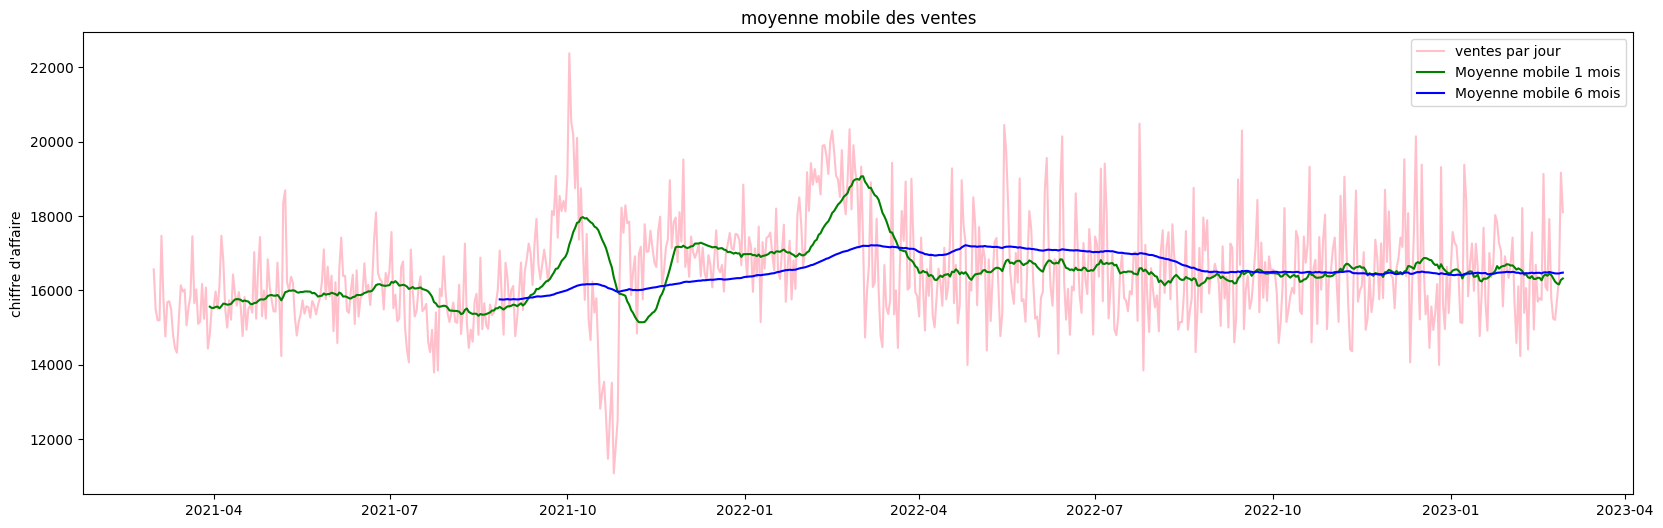

In [23]:


plt.figure(figsize=(20, 6))
plt.plot(ca_day['date'], ca_day['price'], label='ventes par jour', color='pink')

plt.plot(ca_day['date'], ca_day['moy_mob_30j'], label='Moyenne mobile 1 mois', color='green')
plt.plot(ca_day['date'], ca_day['moy_mob_6m'], label='Moyenne mobile 6 mois', color='blue')
plt.xlabel('')
plt.ylabel('chiffre d\'affaire')
plt.title('moyenne mobile des ventes')
plt.legend()
plt.show()

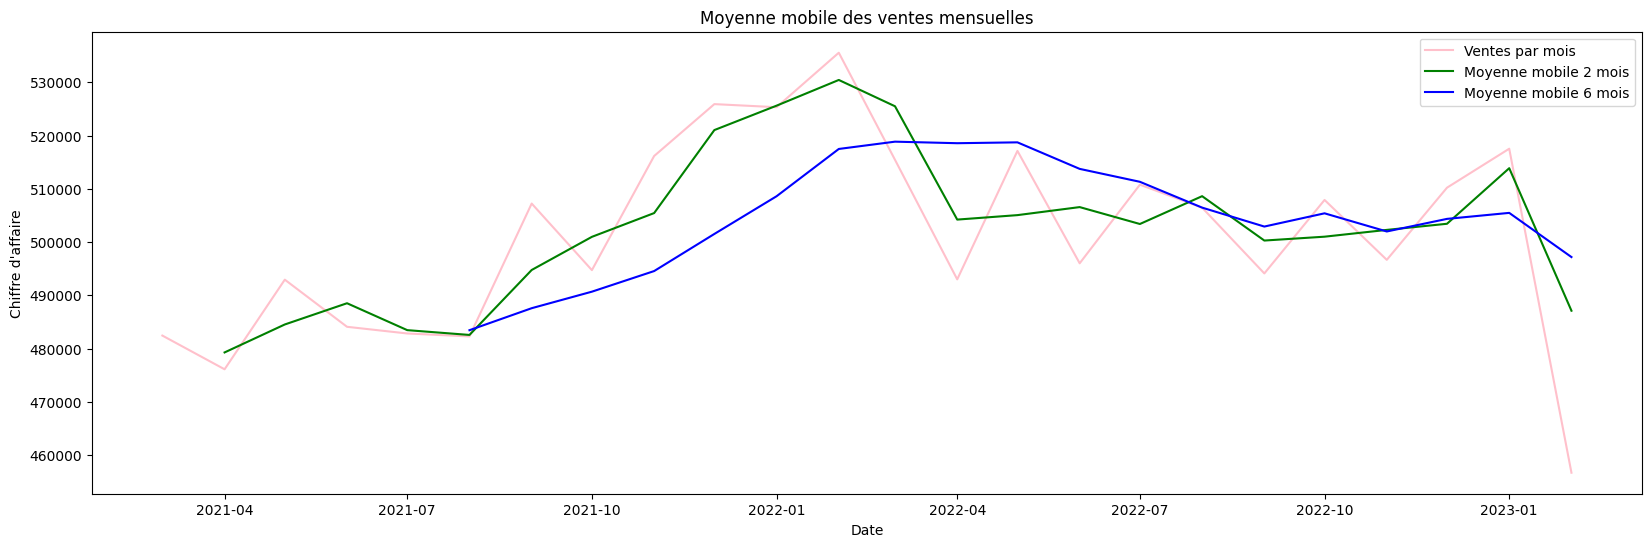

In [24]:

# Créer un DataFrame avec les ventes par mois
ca_month = ca_dt.copy()
ca_month['date_month'] = ca_month['date'].dt.to_period('M')  # Extraire les périodes mensuelles
ca_month = ca_month.groupby('date_month')['price'].sum().reset_index()  # Somme des ventes par mois
ca_month['date_month'] = ca_month['date_month'].dt.to_timestamp()  # Conversion en Timestamp pour Matplotlib

# Calculer les moyennes mobiles sur les ventes mensuelles
ca_month['moy_mob_2m'] = ca_month['price'].rolling(window=2).mean()  # Moyenne mobile 1 mois
ca_month['moy_mob_6m'] = ca_month['price'].rolling(window=6).mean()  # Moyenne mobile 6 mois

# plot
plt.figure(figsize=(20, 6))
plt.plot(ca_month['date_month'], ca_month['price'], label='Ventes par mois', color='pink')
plt.plot(ca_month['date_month'], ca_month['moy_mob_2m'], label='Moyenne mobile 2 mois', color='green')
plt.plot(ca_month['date_month'], ca_month['moy_mob_6m'], label='Moyenne mobile 6 mois', color='blue')


plt.xlabel('Date')
plt.ylabel('Chiffre d\'affaire')
plt.title('Moyenne mobile des ventes mensuelles')
plt.legend()
plt.show()



### Détail du chiffre d'affaire<a id='32'></a>

In [74]:
#ca total
ca_total=round(ca_dt['price'].sum(),2)
print("Chiffre d'affaire :\n\n",ca_total)

#ca par année
ca_annee= ca_dt.copy()
ca_annee['date'] = ca_annee['date'].dt.year
ca_annee=round(ca_annee.groupby('date').sum(),2)
print("\n\n\nChiffe d'affaire par année :\n\n",ca_annee)

#ca par mois et année
ca_mois_annee=ca_dt.copy()
ca_mois_annee['annee'] = ca_mois_annee['date'].dt.year
ca_mois_annee['mois'] = ca_mois_annee['date'].dt.month
ca_mois_annee=ca_mois_annee.groupby(['annee','mois'])['price'].sum()
ca_mois_annee=ca_mois_annee.unstack()
ca_mois_annee.fillna(0, inplace=True)
print("\n\n\nChiffre d'affaire par mois/année :")
ca_mois_annee.T

Chiffre d'affaire :

 12027663.1



Chiffe d'affaire par année :

            price
date            
2021  4944760.98
2022  6108681.81
2023   974220.31



Chiffre d'affaire par mois/année :


annee,2021,2022,2023
mois,,,
1,0.00,525338.99,517540.55
2,0.00,535571.50,456679.76
3,482440.61,515456.53,0.00
4,476109.30,492998.94,0.00
5,492943.47,517132.60,0.00
6,484088.56,496016.12,0.00
7,482835.40,510783.12,0.00
8,482284.79,506467.27,0.00
9,507240.68,494114.53,0.00


In [27]:
#ca min,max, med et moy par mois
ca_mois=ca_dt.copy()
ca_mois['annee'] = ca_mois['date'].dt.year
ca_mois['mois'] = ca_mois['date'].dt.month
ca_mois=ca_mois.groupby(['annee','mois'])['price'].sum()
print('Chiffre d\'affaire sur les mensualités de 2021 à 2023:')
print("\nminimum :",ca_mois.min())
print("\nmaximum :",ca_mois.max())
print("\nmédiane :",ca_mois.median())
print("\nmoyenne :",round(ca_mois.mean(),2))

Chiffre d'affaire sur les mensualités de 2021 à 2023:

minimum : 456679.76

maximum : 535571.5

médiane : 501566.105

moyenne : 501152.63


In [28]:
#ca par catégorie
ca_categ = df.groupby('categ')['price'].sum().reset_index()
ca_categ.columns = ['categ', 'CA_per_categ']
print("Chiffre d'affaire par catégorie :\n\n",ca_categ)

# Affiche le nombre de références dans chaque catégorie
nb_ref = df.groupby('categ')['id_prod'].nunique().reset_index()
nb_ref.columns = ['categ', 'unique_id_prod_count']
print("\n\nNombre de références par catégorie :\n\n",nb_ref)

Chiffre d'affaire par catégorie :

    categ  CA_per_categ
0      0    4419730.97
1      1    4827657.11
2      2    2780275.02


Nombre de références par catégorie :

    categ  unique_id_prod_count
0      0                  2292
1      1                   737
2      2                   236


### Répartition des ventes<a id='33'></a>

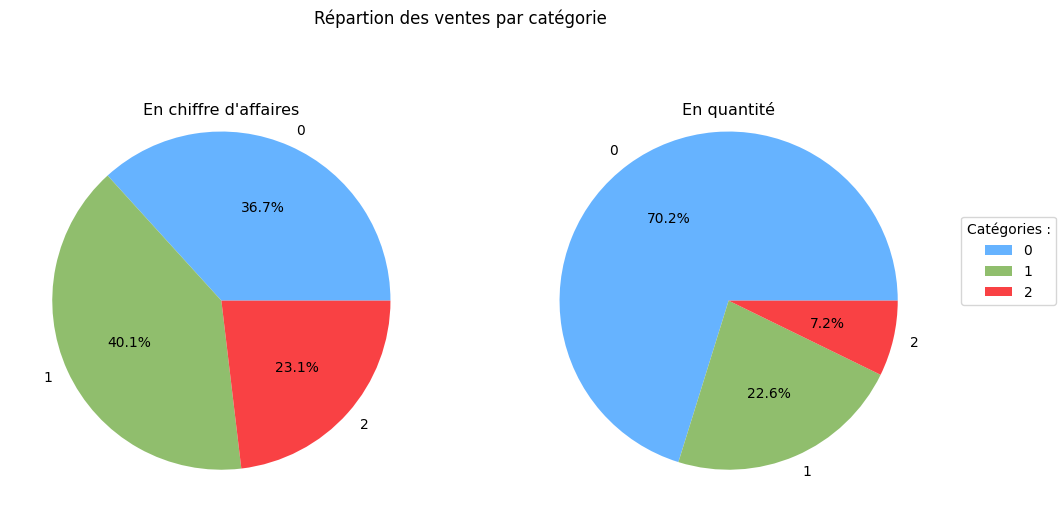

In [29]:
ca_data = ca_categ.groupby('categ')['CA_per_categ'].sum().reset_index()
nb_data = nb_ref.groupby('categ')['unique_id_prod_count'].sum().reset_index()

colors = ['#66b3ff', '#90be6d', '#f94144']

# Création des sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Premier pie plot - chiffre d'affaires
axs[0].pie(ca_data['CA_per_categ'], labels=ca_data['categ'], autopct='%.1f%%',colors=colors)
axs[0].set_title('En chiffre d\'affaires', y=0.92, size=11.5)

# Deuxième pie plot - quantité de références
axs[1].pie(nb_data['unique_id_prod_count'], labels=nb_data['categ'], autopct='%.1f%%',colors=colors)
axs[1].set_title('En quantité', y=0.92, size=11.5)

# Titre global et légende
fig.suptitle('Répartion des ventes par catégorie')
fig.legend(ca_data['categ'], title='Catégories :', loc='center right')

plt.show()


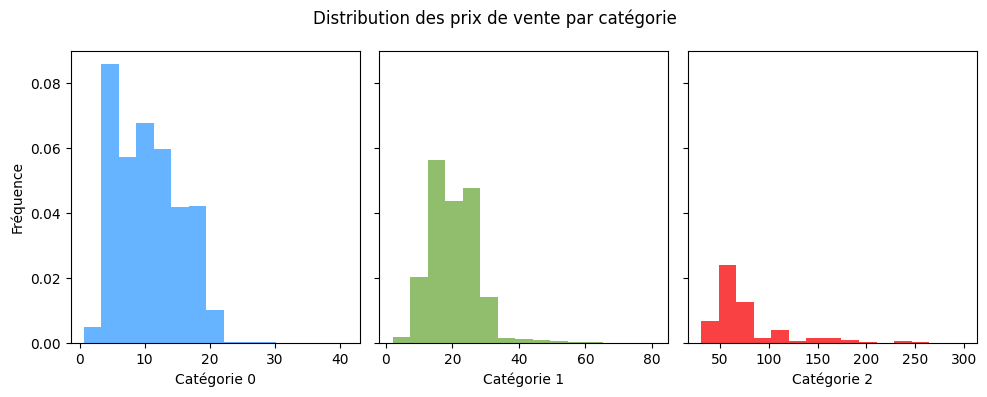

In [30]:
distri = df.drop_duplicates(subset=['id_prod'], keep='first')[['id_prod', 'categ', 'price']]

distri = distri['categ'].unique()
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

colors = ['#66b3ff', '#90be6d', '#f94144']

for i in range(len(distri)):
    prix_per_categ = df.loc[df['categ'] == i, :]

    axs[i].hist(prix_per_categ['price'], bins=15, zorder=2,
                density=True, color=colors[i])
    
    axs[i].set_xlabel('Catégorie ' + str(i))

axs[0].set_ylabel('Fréquence')

fig.suptitle('Distribution des prix de vente par catégorie')

plt.tight_layout()
plt.show()


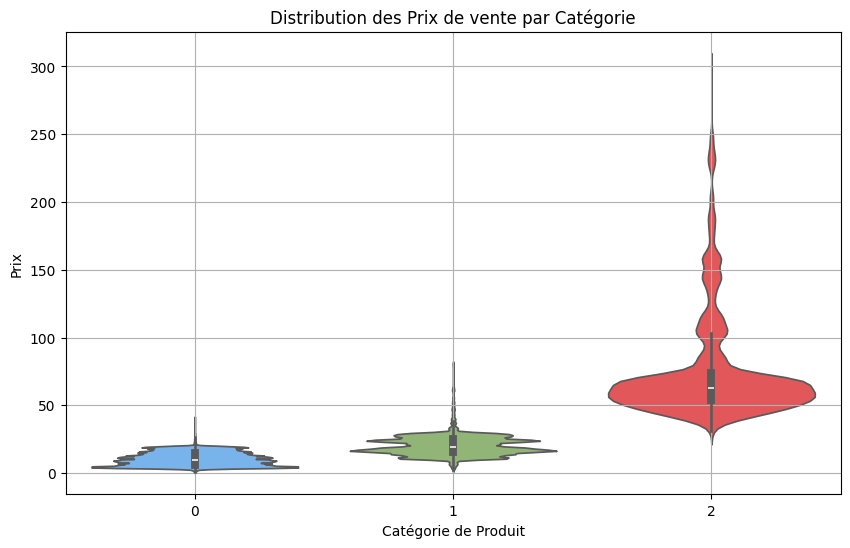

In [31]:

plt.figure(figsize=(10, 6))
sns.violinplot(x='categ', y='price', data=df, hue='categ', palette=['#66b3ff', '#90be6d', '#f94144'], legend=False)

plt.title("Distribution des Prix de vente par Catégorie")
plt.xlabel("Catégorie de Produit")
plt.ylabel("Prix")
plt.grid()
plt.show()

Rapelle sur la fréquence : En statistique, on appelle fréquence absolue l'effectif des observations d'une classe et fréquence relative ou simplement fréquence, le quotient de cet effectif par celui de la population. 

fréquence = taille classe / taille population

### Détail sur les nombre de transactions, clients, ventes par mensualités<a id='34'></a>

In [32]:

df_describ = df.drop_duplicates(subset=['id_prod'], keep='first')[
    ['id_prod', 'categ', 'price']]

display(df.groupby('categ')['price'].describe().T)


categ,0,1,2
count,415459.000000,235592.000000,36483.000000
mean,10.638188,20.491600,76.207412
std,4.933527,7.579606,39.749015
min,0.620000,2.000000,30.990000
25%,6.290000,15.810000,53.990000
50%,9.990000,19.080000,62.830000
75%,14.450000,24.980000,73.720000
max,40.990000,80.990000,300.000000


In [75]:
#nb de clients par mois
nb_client=df[['date','client_id']].copy()
nb_client['annee'] = nb_client['date'].dt.year
nb_client['mois'] = nb_client['date'].dt.month
nb_client=nb_client.groupby(['annee','mois'])['client_id'].nunique()


print('nombre de clients sur les mensualités de 2021 à 2023:')
print("\nminimum :",nb_client.min())
print("\nmaximum :",nb_client.max())
print("\nmédiane :",nb_client.median())
print("\nmoyenne :",nb_client.mean())
print("\nnombre de client unique : ",df['client_id'].nunique())

unstack_nbclient=nb_client.unstack()
unstack_nbclient.fillna(0, inplace=True)
print("\n\n nombre de clients par mois/années :")
unstack_nbclient.T


nombre de clients sur les mensualités de 2021 à 2023:

minimum : 5587

maximum : 6190

médiane : 5743.5

moyenne : 5759.375

nombre de client unique :  8600


 nombre de clients par mois/années :


annee,2021,2022,2023
mois,,,
1,0.0,5809.0,5828.0
2,0.0,5729.0,5587.0
3,5676.0,5835.0,0.0
4,5674.0,5695.0,0.0
5,5644.0,5843.0,0.0
6,5659.0,5717.0,0.0
7,5672.0,5778.0,0.0
8,5642.0,5805.0,0.0
9,5693.0,5738.0,0.0


In [34]:
#nb de transactions par mois
nb_transac=df[['date','session_id']].copy()
nb_transac['annee'] = nb_transac['date'].dt.year
nb_transac['mois'] = nb_transac['date'].dt.month
nb_transac=nb_transac.groupby(['annee','mois'])['session_id'].nunique()


print('nombre de transactions sur les mensualités de 2021 à 2023:')
print("\nminimum :",nb_transac.min())
print("\nmaximum :",nb_transac.max())
print("\nmédiane :",nb_transac.median())
print("\nmoyenne :",round(nb_transac.mean(),2))
print("\nnombre de transaction unique : ",df['session_id'].nunique())

unstack_nbclient=nb_transac.unstack()
unstack_nbclient.fillna(0, inplace=True)
print("\n\n nombre de transactions par mois/années :")
unstack_nbclient

nombre de transactions sur les mensualités de 2021 à 2023:

minimum : 13073

maximum : 15566

médiane : 14487.0

moyenne : 14398.17

nombre de transaction unique :  345505


 nombre de transactions par mois/années :


mois,1,2,3,4,5,6,7,8,9,10,11,12
annee,,,,,,,,,,,,
2021,0.0,0.0,14201.0,13970.0,14168.0,13838.0,13571.0,13591.0,14848.0,14781.0,14605.0,15566.0
2022,14978.0,14337.0,14826.0,14084.0,14957.0,14389.0,14651.0,14585.0,14263.0,14658.0,14224.0,14634.0
2023,14758.0,13073.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#nb de produits par mois
nb_prod=df[['date','id_prod']].copy()
nb_prod['annee'] = nb_prod['date'].dt.year
nb_prod['mois'] = nb_prod['date'].dt.month
nb_prod=nb_prod.groupby(['annee','mois'])['id_prod'].nunique()


print('nombre de produits vendus sur les mensualités de 2021 à 2023:')
print("\nminimum :",nb_prod.min())
print("\nmaximum :",nb_prod.max())
print("\nmédiane :",nb_prod.median())
print("\nmoyenne :",round(nb_prod.mean(),2))
print("\nnombre de produits unique : ",df['id_prod'].nunique())

unstack_nbclient=nb_prod.unstack()
unstack_nbclient.fillna(0, inplace=True)
print("\n\n nombre de réferences produits vendus par mois/années :")
unstack_nbclient

nombre de produits vendus sur les mensualités de 2021 à 2023:

minimum : 2369

maximum : 2560

médiane : 2470.0

moyenne : 2462.88

nombre de produits unique :  3265


 nombre de réferences produits vendus par mois/années :


mois,1,2,3,4,5,6,7,8,9,10,11,12
annee,,,,,,,,,,,,
2021,0.0,0.0,2482.0,2492.0,2471.0,2414.0,2369.0,2404.0,2560.0,2506.0,2432.0,2505.0
2022,2470.0,2477.0,2474.0,2462.0,2485.0,2451.0,2470.0,2463.0,2452.0,2489.0,2448.0,2438.0
2023,2488.0,2407.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Zoom sur la chute des ventes<a id='35'></a>

In [36]:
#gap fin 2021
mask = (df['date'] > '2021-9-30') & (df['date'] <= '2021-11-01')
gap=df.loc[mask]
gap=gap[['date','price']].copy()
print(gap.dtypes)
print("\n",gap.head(3),"\n\n",gap.tail(3))

date     datetime64[ns]
price           float64
dtype: object

              date  price
195881 2021-10-01   6.99
195882 2021-10-01  17.41
195883 2021-10-01  19.96 

              date  price
226835 2021-11-01  32.99
226836 2021-11-01  13.99
226837 2021-11-01  18.87


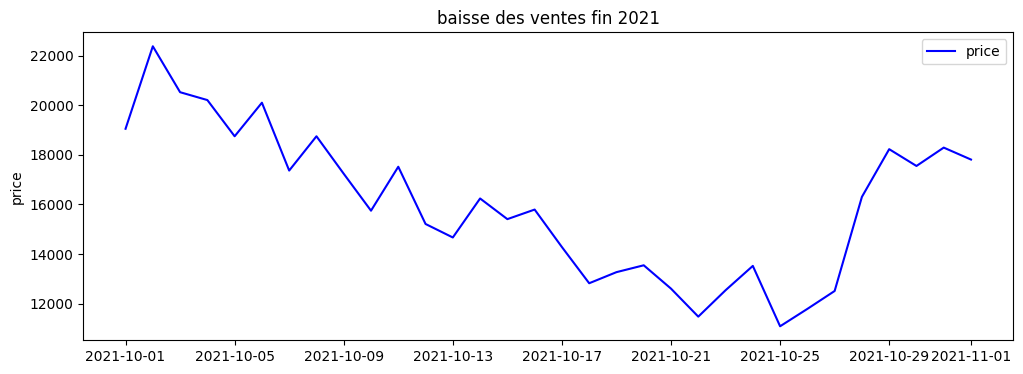

In [37]:
#plt

gap = gap.sort_values('date').copy()
gap = gap.groupby('date').sum().reset_index()
date_range = pd.date_range(start=gap['date'].min(), end=gap['date'].max())#ajouter les dates sans transactions
gap = gap.set_index('date').reindex(date_range, fill_value=0).rename_axis('date').reset_index()#intégrer les jours manquant au dataframe

plt.figure(figsize=(12, 4))
plt.plot(gap['date'], gap['price'], label='price', color='blue')
plt.xlabel('')
plt.ylabel('price')
plt.title('baisse des ventes fin 2021')
plt.legend()
plt.show()

In [38]:
print("chiffre maximum + date dans cette période :\n",gap.loc[gap['price'].idxmax()])
print("\n\nchiffre minimum + date dans cette période :\n",gap.loc[gap['price'].idxmin()])

chiffre maximum + date dans cette période :
 date     2021-10-02 00:00:00
price               22382.43
Name: 1, dtype: object


chiffre minimum + date dans cette période :
 date     2021-10-25 00:00:00
price               11080.75
Name: 24, dtype: object


### Top et Flop<a id='36'></a>

In [39]:
top_flop=df[["id_prod","price"]]
ca_pd=top_flop.groupby('id_prod')['price'].sum().reset_index()
ca_pd.columns=['id_prod','CA']

qt_pd=top_flop.groupby('id_prod').size().reset_index(name='nb')
top_flop=pd.merge(ca_pd,qt_pd,on='id_prod')

top_ca = top_flop.sort_values('CA',ascending=False).reset_index().head(10).drop(columns=["index"])#top chiffre d'affaire

flop_ca = top_flop.sort_values('CA',ascending=True).reset_index().head(10).drop(columns=["index"])#flop chiffre d'affaire

top_nb = top_flop.sort_values('nb',ascending=False).reset_index().head(10).drop(columns=["index"])#top chiffre prodruits les plus vendus

flop_nb = top_flop.sort_values('nb',ascending=True).reset_index().head(10).drop(columns=["index"])#flop chiffre prodruits les plus vendus

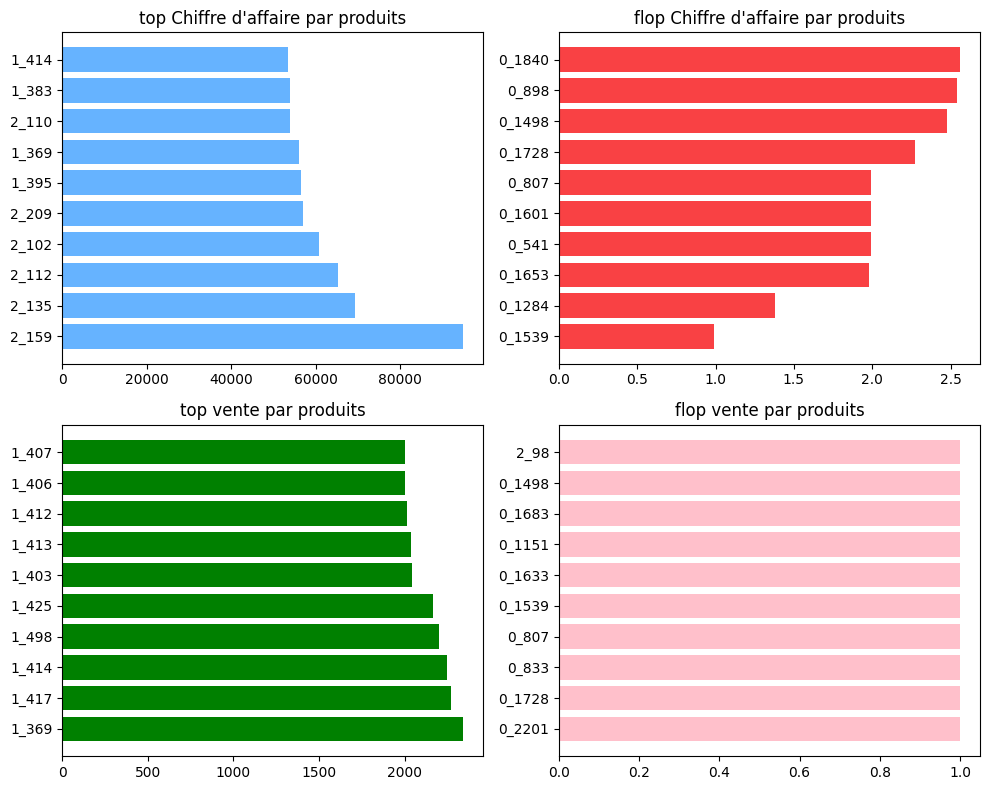

In [40]:
# Créer une figure et des sous-graphiques (axes)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Grille 2x2 pour les 4 bar plots

# Plot pour top_ca
axs[0, 0].barh(top_ca['id_prod'], top_ca['CA'],color='#66b3ff')
axs[0, 0].set_title('top Chiffre d\'affaire par produits')

# Plot pour df2
axs[0, 1].barh(flop_ca['id_prod'], flop_ca['CA'],color='#f94144')
axs[0, 1].set_title('flop Chiffre d\'affaire par produits')

# Plot pour df3
axs[1, 0].barh(top_nb['id_prod'], top_nb['nb'],color='green')
axs[1, 0].set_title('top vente par produits')

# Plot pour df4
axs[1, 1].barh(flop_nb['id_prod'], flop_nb['nb'],color='pink')
axs[1, 1].set_title('flop vente par produits')


# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


### Distribution des prix<a id='37'></a>

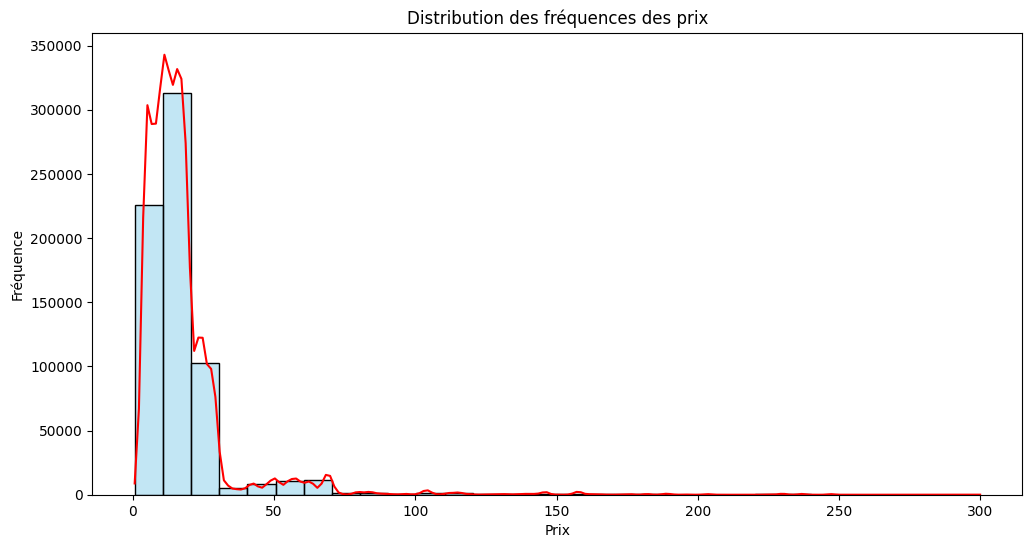

In [41]:
# Histogramme pour visualiser les fréquences des prix
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True, color='skyblue')  # kde=True ajoute la courbe de densité sur l'histogramme

for line in plt.gca().lines:
    line.set_color("red")  # Modifier la couleur de la courbe KDE
    
plt.xlabel("Prix")
plt.ylabel("Fréquence")
plt.title("Distribution des fréquences des prix")
plt.show()


### Zoom sur le profil client<a id='38'></a>

In [42]:
topclient=df.groupby('client_id')['price'].sum()
print("top 10 des clients les plus fidèle :\n",topclient.nlargest(10))
print("\n\ntop 10 des clients les moins dépensiés :\n",topclient.nsmallest(10))

top 10 des clients les plus fidèle :
 client_id
1609    326039.89
4958    290227.03
6714    153918.60
3454    114110.57
1570      5285.82
3263      5276.87
2140      5260.18
2899      5214.05
7319      5155.77
7959      5135.75
Name: price, dtype: float64


top 10 des clients les moins dépensiés :
 client_id
8351     6.31
8140     8.30
8114     9.98
4648    11.20
4478    13.36
6040    15.72
5919    15.98
5829    16.07
8032    17.64
4976    17.89
Name: price, dtype: float64


In [43]:
mois = df['date'].dt.to_period("M").nunique() #compte le nombre de mois présent dans le df.
comsomation_mensuelle=df.groupby('client_id')['price'].sum()/24
print("top 10 des clients les plus fidèle et leur consomation mensuelle moyenne :\n",round(comsomation_mensuelle.nlargest(10)),2)

top 10 des clients les plus fidèle et leur consomation mensuelle moyenne :
 client_id
1609    13585.0
4958    12093.0
6714     6413.0
3454     4755.0
1570      220.0
3263      220.0
2140      219.0
2899      217.0
7319      215.0
7959      214.0
Name: price, dtype: float64 2


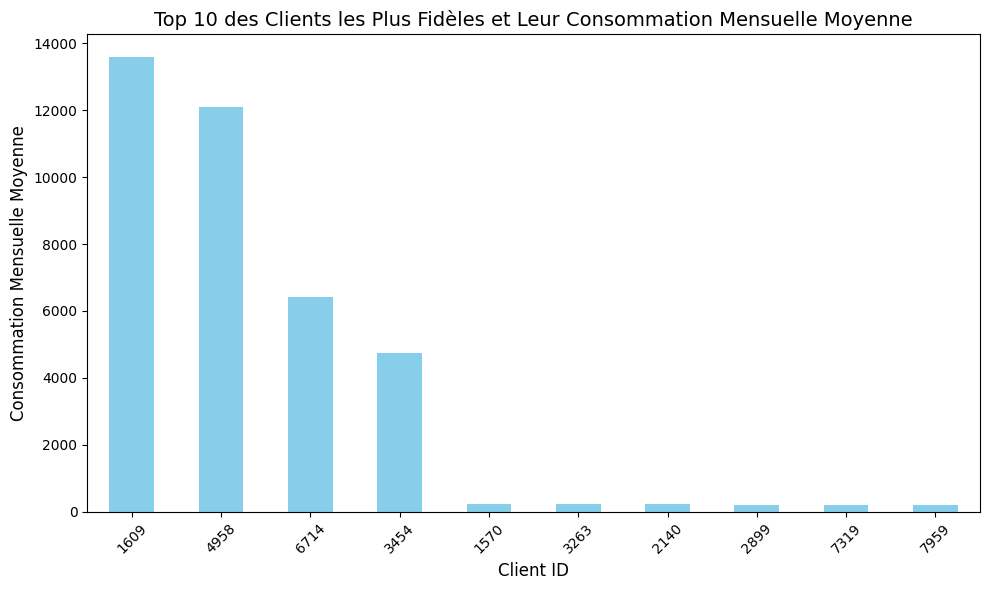

In [44]:
top_10_clients = comsomation_mensuelle.nlargest(10)
# Création du bar plot
plt.figure(figsize=(10, 6))  # Taille du graphique
top_10_clients.plot(kind='bar', color='skyblue')

# Ajouter des titres et labels
plt.title("Top 10 des Clients les Plus Fidèles et Leur Consommation Mensuelle Moyenne", fontsize=14)
plt.xlabel("Client ID", fontsize=12)
plt.ylabel("Consommation Mensuelle Moyenne", fontsize=12)
plt.xticks(rotation=45)  # Rotation des labels des clients pour plus de lisibilité

# Afficher le graphique
plt.tight_layout()  # Ajuste les éléments du graphique pour qu'ils s'adaptent bien à la taille
plt.show()

Certains client font de achats bien suppérieur a ce qui considéré comme de la consomation individuel.
Nous considererons qu'ils sont des professionnels achetetant des stcoks bien plus importans.

In [45]:
clients_pro=topclient.nlargest(4).copy()
print("clients pro :\n",clients_pro)

clients pro :
 client_id
1609    326039.89
4958    290227.03
6714    153918.60
3454    114110.57
Name: price, dtype: float64


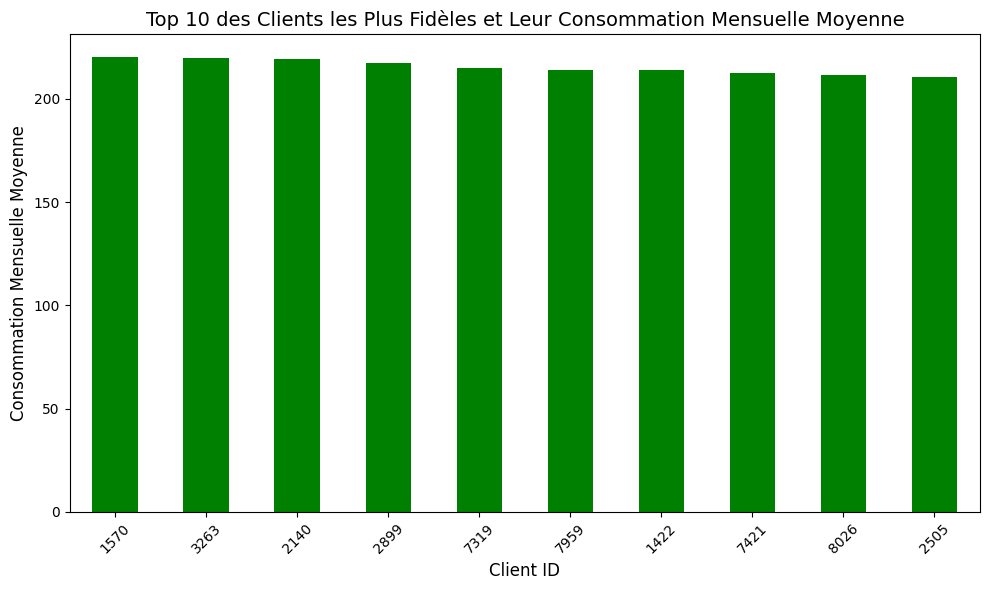

In [46]:
pro_id=[1609,4958,6714,3454]
top_casu=comsomation_mensuelle[~topclient.index.isin(pro_id)].nlargest(10)
# Création du bar plot
plt.figure(figsize=(10, 6))  # Taille du graphique
top_casu.plot(kind='bar', color='green')

# Ajouter des titres et labels
plt.title("Top 10 des Clients les Plus Fidèles et Leur Consommation Mensuelle Moyenne", fontsize=14)
plt.xlabel("Client ID", fontsize=12)
plt.ylabel("Consommation Mensuelle Moyenne", fontsize=12)
plt.xticks(rotation=45)  # Rotation des labels des clients pour plus de lisibilité

# Afficher le graphique
plt.tight_layout()  # Ajuste les éléments du graphique pour qu'ils s'adaptent bien à la taille
plt.show()

In [47]:
print("top 10 des clients non professionels par consomation moyenne mensuelle : ")
top_casu #top 10 des client hors pro.

top 10 des clients non professionels par consomation moyenne mensuelle : 


client_id
1570    220.242500
3263    219.869583
2140    219.174167
2899    217.252083
7319    214.823750
7959    213.989583
1422    213.806667
7421    212.382500
8026    211.774167
2505    210.806250
Name: price, dtype: float64

In [48]:

countsex = df[['client_id', 'sex']].drop_duplicates(subset=['client_id'])

# Calculer la répartition en pourcentage des sexes
count_values = countsex['sex'].value_counts(normalize=True)

# Afficher les résultats avec une mise en forme des pourcentages
print("Répartition par sexe :")
for sex, proportion in count_values.items():
    print(f"- {sex} : {proportion:.1%}")


Répartition par sexe :
- f : 52.1%
- m : 47.9%


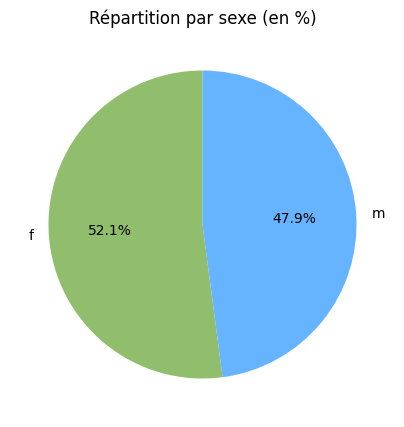

In [49]:

plt.figure(figsize=(5, 5))
plt.pie(
    count_values,
    labels=count_values.index,  # Utilise les valeurs uniques de `sex` comme étiquettes (M et F)
    autopct='%1.1f%%',  # Affiche les pourcentages avec une décimale
    startangle=90,  # Oriente le premier secteur pour commencer en haut
    colors=['#90be6d', '#66b3ff']  # Personnalisation des couleurs
)
plt.title("Répartition par sexe (en %)")
plt.show()


In [50]:
sex_descri=df.drop_duplicates(subset=["client_id"])[['sex','age']]
sex_descri=sex_descri.groupby(['sex'])['age'].describe()
sex_descri

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
f,4479.0,46.027238,17.091344,20.0,32.0,45.0,58.0,95.0
m,4121.0,45.426353,16.704484,20.0,32.0,44.0,58.0,95.0


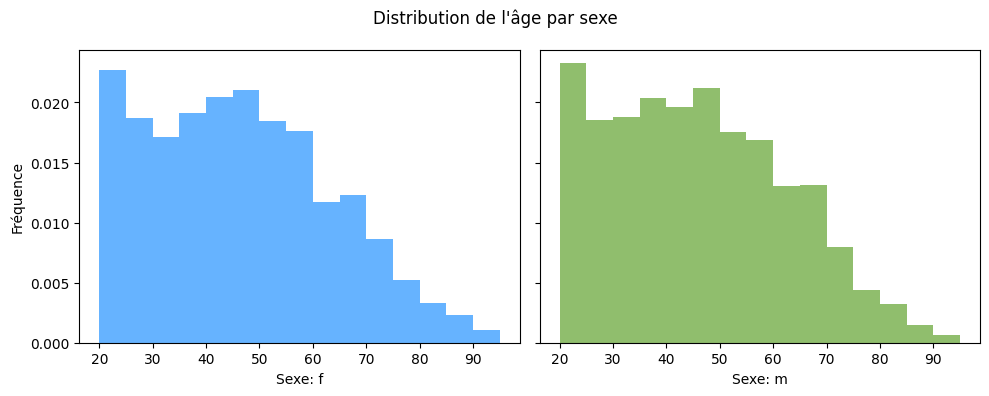

In [51]:
# Filtrer les doublons sur client_id
age_plot = df.drop_duplicates(subset=['client_id'], keep='first')

# Variables uniques pour les sexes
sexes = list(age_plot['sex'].unique())

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
colors = ['#66b3ff', '#90be6d']

# Boucle pour chaque sexe
for i, sex in enumerate(sexes):
    client_p_age = age_plot.loc[age_plot['sex'] == sex, :]
    
    # Histogramme
    axs[i].hist(client_p_age['age'], bins=15, zorder=2, density=True, color=colors[i])
    
    # Titre de chaque sous-graphe
    axs[i].set_xlabel('Sexe: ' + sex)

# Label pour l'axe y commun
axs[0].set_ylabel('Fréquence')

# Titre de la figure
fig.suptitle("Distribution de l'âge par sexe")

# Ajustement de la disposition
plt.tight_layout()
plt.show()

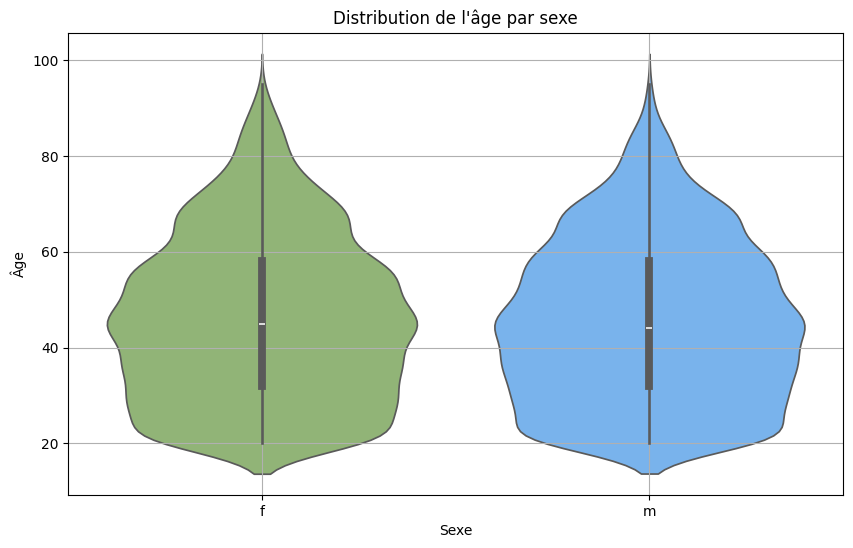

In [76]:

# Filtrer les doublons sur client_id
age_plot = df.drop_duplicates(subset=['client_id'], keep='first')

# Variables uniques pour les sexes
sexes = list(age_plot['sex'].unique())

# Création du graphique
plt.figure(figsize=(10, 6))

# Création du violin plot
sns.violinplot(x='sex', y='age', data=age_plot,hue='sex', palette=['#90be6d','#66b3ff'])

# Titres et labels
plt.title("Distribution de l'âge par sexe")
plt.xlabel("Sexe")
plt.ylabel("Âge")
plt.grid()

# Affichage du graphique
plt.show()

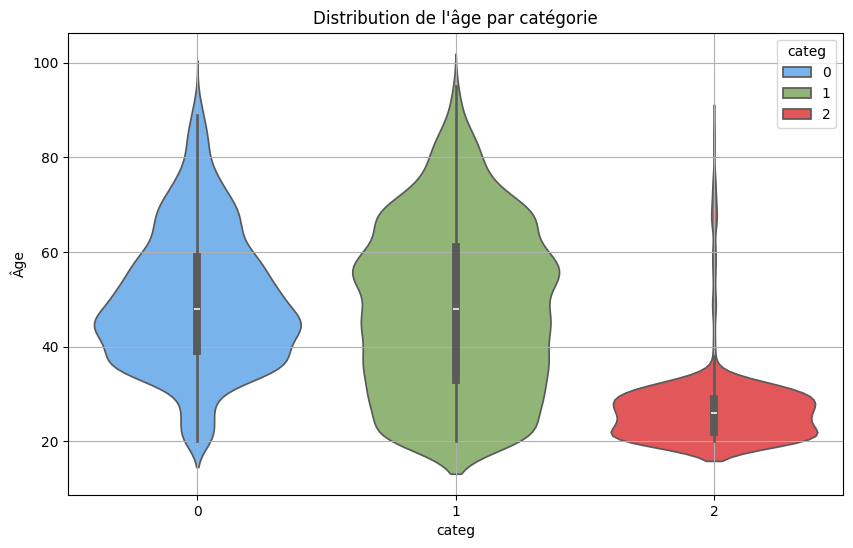

In [53]:

# Filtrer les doublons sur client_id
age_categ = df.drop_duplicates(subset=['client_id'], keep='first')

# Variables uniques pour les sexes
categ=["0","1","2"]

# Création du graphique
plt.figure(figsize=(10, 6))

# Création du violin plot
sns.violinplot(x='categ', y='age', data=age_categ,hue='categ', palette=['#66b3ff', '#90be6d','#f94144'])

# Titres et labels
plt.title("Distribution de l'âge par catégorie")
plt.xlabel("categ")
plt.ylabel("Âge")
plt.grid()

# Affichage du graphique
plt.show()

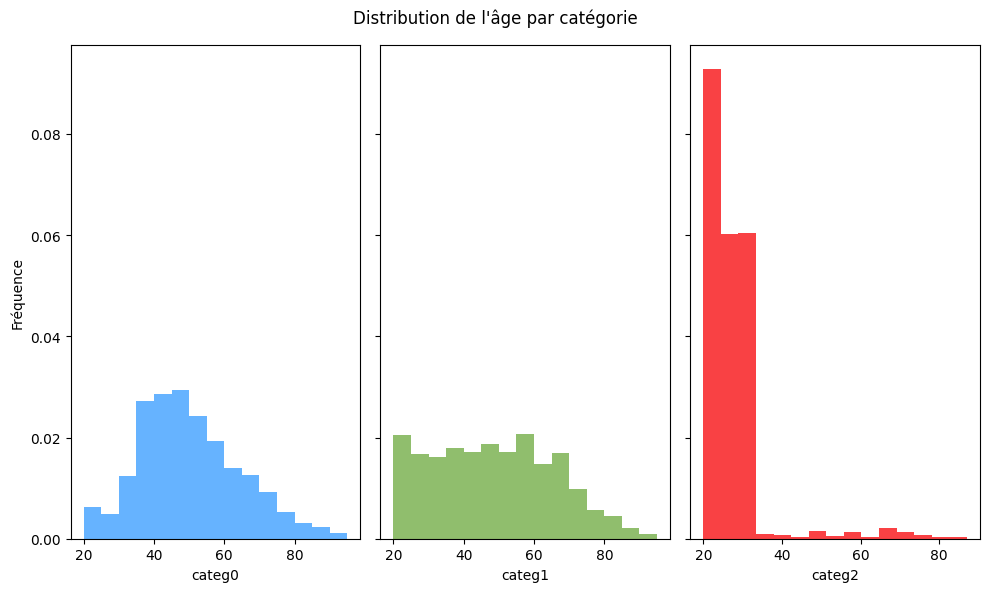

In [54]:
# Filtrer les doublons sur client_id
age_categ = df.drop_duplicates(subset=['client_id'], keep='first')

# Variables uniques pour les categ
#categ = list(age_plot['categ'].unique())
categ=["0","1","2"]

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
colors = ['#66b3ff', '#90be6d','#f94144']

# Boucle pour chaque sexe
for i, cat in enumerate(categ):
    age_per_categ = age_plot.loc[age_plot['categ'] == int(cat), :]


    
    # Histogramme
    axs[i].hist(age_per_categ['age'], bins=15, zorder=2, density=True, color=colors[i])
    
    # Titre de chaque sous-graphe
    axs[i].set_xlabel("categ"+ cat)

# Label pour l'axe y commun
axs[0].set_ylabel('Fréquence')

# Titre de la figure
fig.suptitle("Distribution de l'âge par catégorie")

# Ajustement de la disposition
plt.tight_layout()
plt.show()

### Courbe de Lorenz<a id='39'></a>


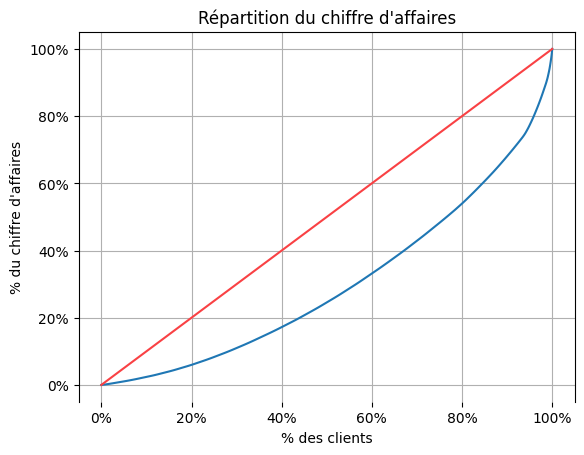

In [55]:
# Trace la courbe de Lorenz chiffre d'affaires/clients
lorenz = df.groupby('client_id', as_index=False)['price'].sum()

prix = df['price']
n_prix = len(prix)
cum_prix = np.cumsum(np.sort(prix)) / prix.sum()
cum_prix = np.append([0], cum_prix)

cum_client = np.linspace(0-1/n_prix, 1+1/n_prix, len(cum_prix))

fig, ax = plt.subplots()

ax.plot(cum_client, cum_prix, drawstyle='steps-post')
ax.plot([0, 1], [0, 1], color='#f94144')

ax.grid(True)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

ax.set_title('Répartition du chiffre d\'affaires')
ax.set_xlabel('% des clients')
ax.set_ylabel('% du chiffre d\'affaires')

plt.show()
#courbe de lorenz, voir si le CA est répartit de manière égale entre les clients.

### heatmap de la fréquence de fréquentation<a id='40'></a>

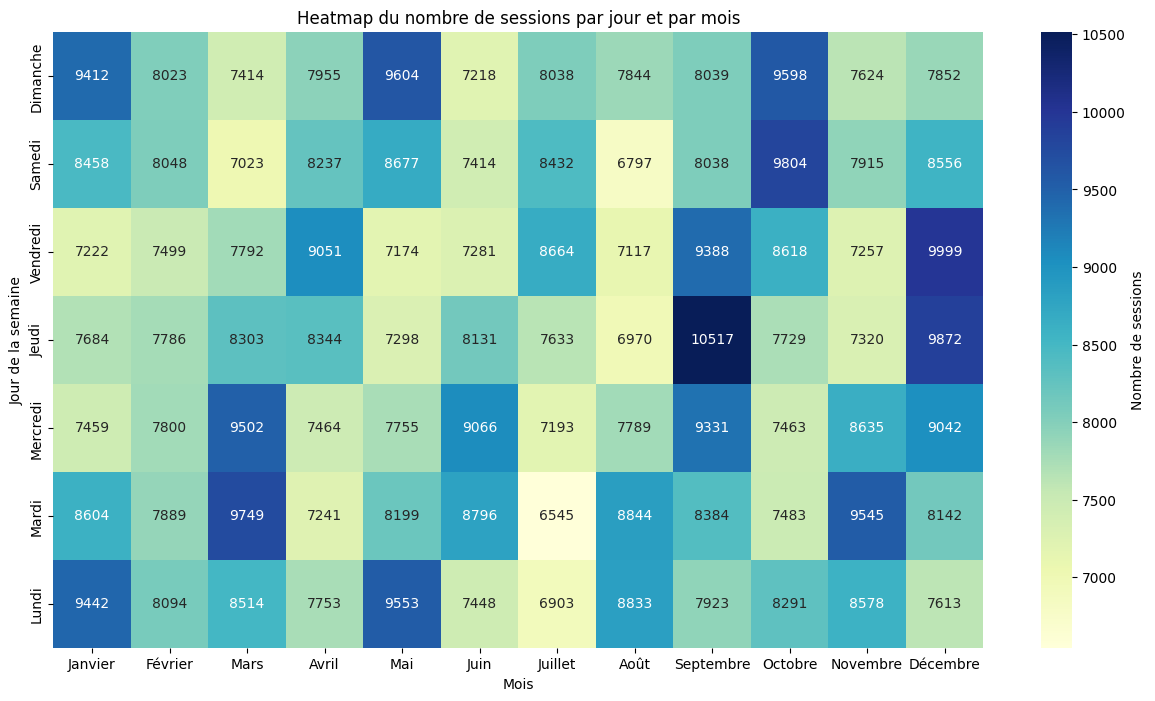

In [77]:


# en premier lieux, on extrait les jours et les mois pour savoir quand les usagés se connectent le plus souvent.

df_week=df[['session_id','date']].copy()
df_week['jour']=df_week['date'].dt.day_of_week
df_week['mois']=df_week['date'].dt.month

mois_noms = {1: 'Janvier', 2: 'Février', 3: 'Mars', 4: 'Avril',5: 'Mai', 6: 'Juin', 7: 'Juillet', 8: 'Août',9: 'Septembre', 10: 'Octobre', 11: 'Novembre', 12: 'Décembre'}

jours_noms = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi',4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}


df_week['mois'] = df_week['mois'].map(mois_noms)
df_week['jour'] = df_week['jour'].map(jours_noms)

sessions_par_jour_mois = df_week.groupby(['mois', 'jour'])['session_id'].count().reset_index()
sessions_par_jour_mois = sessions_par_jour_mois.rename(columns={'session_id': 'nb_sessions'})

heatmap_data = sessions_par_jour_mois.pivot(index='jour', columns='mois', values='nb_sessions')

# Optionnel : pour s'assurer de l'ordre correct des jours et des mois dans la heatmap
jours = ['Dimanche', 'Samedi', 'Vendredi', 'Jeudi', 'Mercredi', 'Mardi', 'Lundi']
mois = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

# Réindexer les lignes et colonnes pour que les jours et mois soient dans l'ordre voulu
heatmap_data = heatmap_data.reindex(index=jours, columns=mois)

# Tracer la heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Nombre de sessions'})
plt.title("Heatmap du nombre de sessions par jour et par mois")
plt.xlabel("Mois")
plt.ylabel("Jour de la semaine")
plt.show()

### Age des clients et panier moyen<a id='41'></a>


   client_id  age  panier_moyen
0          1   69         18.50
1          2   48         23.41
2          3   45         27.96


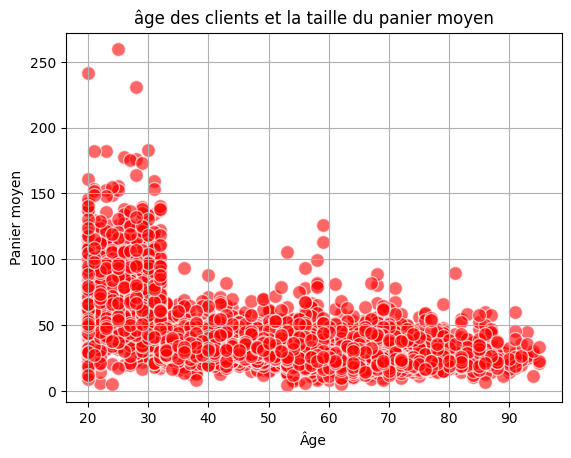

In [57]:

# 1. Calcul du panier par session pour chaque client
panier_par_session = df.groupby(['client_id', 'session_id'])['price'].sum().reset_index(name='panier')

# 2. Calcul du panier moyen par client
panier_moyen_par_client = panier_par_session.groupby('client_id')['panier'].mean().reset_index(name='panier_moyen')

# 3. Fusion avec l'âge du client
panier = pd.merge(panier_moyen_par_client, df[['client_id', 'age']].drop_duplicates(), on='client_id', how='left')

panier['panier_moyen']=panier['panier_moyen'].round(2)
# 4. Affichage des résultats
print(panier[['client_id', 'age', 'panier_moyen']].head(3))

plt.scatter(panier['age'], panier['panier_moyen'], c='red', s=100, edgecolors='white', alpha=0.6)
plt.title("âge des clients et la taille du panier moyen")
plt.xlabel('Âge')
plt.ylabel('Panier moyen')
plt.grid()
plt.show()




## 4. Tests statistique.<a id='50'></a>
[retourner au sommaire](#60)


## Normalité de la distribution des prix et de l'âge<a id='51'></a>

pour le teste statistique : plus on es tproche de 1 plus la distribution est considéré normale

pour la valeur P : Si p-value < 0.05 (ou autre seuil choisi, comme 0.01 ou 0.10), on rejette l'hypothèse nulle, ce qui signifie que les données ne suivent pas une distribution normale.
Si p-value ≥ 0.05, on ne rejette pas l'hypothèse nulle, ce qui signifie qu'on peut considérer que les données suivent une distribution normale.

Statistique du test : 0.9963608601166387 
p_value : 0.0
Les prix ne suivent pas une distribution normale (rejeter H0).


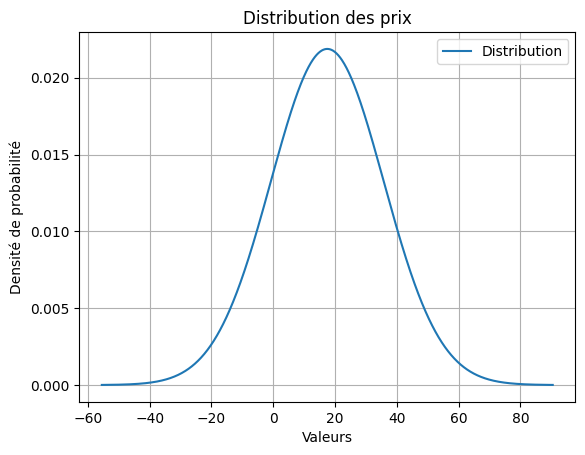

In [59]:
# Test de normalité avec Kolmogorov-Smirnov plutôt que shapiro puisque kes échantillons sont assez large.

stat, p_value = kstest(df['price'], 'norm')
print(f"Statistique du test : {stat}",f"\np_value : {p_value}")
if p_value < 0.05:
    print("Les prix ne suivent pas une distribution normale (rejeter H0).")
else:
    print("Les prix suivent une distribution normale (ne pas rejeter H0).")


#visualisation du test
# Paramètres de la distribution
price_list=df['price'].tolist()

mu = statistics.mean(price_list)       # moyenne
sigma = np.std(price_list)    # écart-type

# Générer des valeurs x
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)



# Calculer la densité de probabilité
y = stats.norm.pdf(x, mu, sigma)

# Tracer la distribution normale
plt.plot(x, y, label='Distribution')
plt.title('Distribution des prix')
plt.xlabel('Valeurs')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid()
plt.show()

Statistique du test : 1.0
P-value : 0.0
Les âges ne suivent pas une distribution normale (rejeter H0).


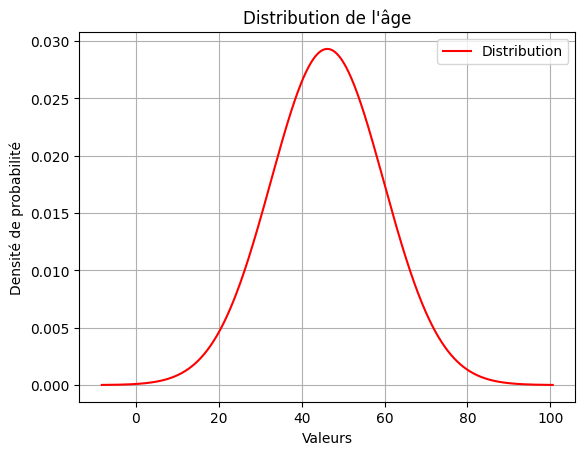

In [62]:


# Regrouper par client_id et sélectionner un seul âge par client
df_age_unique = df.groupby("client_id")["age"].first()

# Appliquer le test de Kolmogorov-Smirnov sur les âges uniques
stat, p_value = kstest(df_age_unique,'norm')

print(f"Statistique du test : {stat}")
print(f"P-value : {p_value}")

if p_value < 0.05:
    print("Les âges ne suivent pas une distribution normale (rejeter H0).")
else:
    print("Les âges suivent une distribution normale (ne pas rejeter H0).")
    
#visualisation du test
# Paramètres de la distribution
price_list=df['age'].tolist()

mu = statistics.mean(price_list)       # moyenne
sigma = np.std(price_list)    # écart-type

# Générer des valeurs x
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)

# Calculer la densité de probabilité
y = stats.norm.pdf(x, mu, sigma)

# Tracer la distribution normale
plt.plot(x, y,color='red', label='Distribution')
plt.title('Distribution de l\'âge')
plt.xlabel('Valeurs')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid()
plt.show()


### Après avoir constaté que la distribution était non-normale, les tests qui suivront seront non-paramétrique.

## Analyse des Proportions et Tests d’Indépendance entre le sexe et la catégorie<a id='52'></a>

Test du Chi-carré : pour analyser l’indépendance entre deux variables catégorielles (ex. : sexe et catégorie de produit).
Test de proportion : pour vérifier si la proportion d’un sous-groupe diffère significativement d’une proportion hypothétique.

In [ ]:
table = pd.crosstab(df['sex'], df['categ'])
chi2, p, dof, expected = chi2_contingency(table)
print(f" chi2 : {chi2}",
      f"\n\n valeur-p : {p}",
      f"\n\n degré de liberté (dof) : {dof}", #degré de liberté
      f"\n\n table des effectifs attendus : {expected}") #table des effectifs attendus

 chi2 : 158.25417617304882 

 valeur-p : 4.3205822283997063e-35 

 degré de liberté (dof) : 2 

 table des effectifs attendus : [[207080.50959953 117427.98066132  18184.50973915]
 [208378.49040047 118164.01933868  18298.49026085]]


La table des effectifs attendus représente les comptes hypothétiques que l’on observerait dans chaque cellule du tableau si les deux variables étaient réellement indépendantes.

Effectif attendu = (total ligne X total colonne) / total général(total ligne X total colonne)/total général


Supposons que vous obteniez une valeur-p très faible (par exemple, p = 0,001). Cela signifierait qu’il est très peu probable que les différences entre les effectifs observés et attendus soient dues au hasard, et donc que sex et categ sont probablement associés.

Si, en revanche, p est supérieur à 0,05, cela signifierait que les écarts entre les effectifs observés et attendus pourraient être dus au hasard, et on conclurait que sex et categ sont indépendants.

## Comparaison de la table des effectifs attendus entre catégorie et sexe

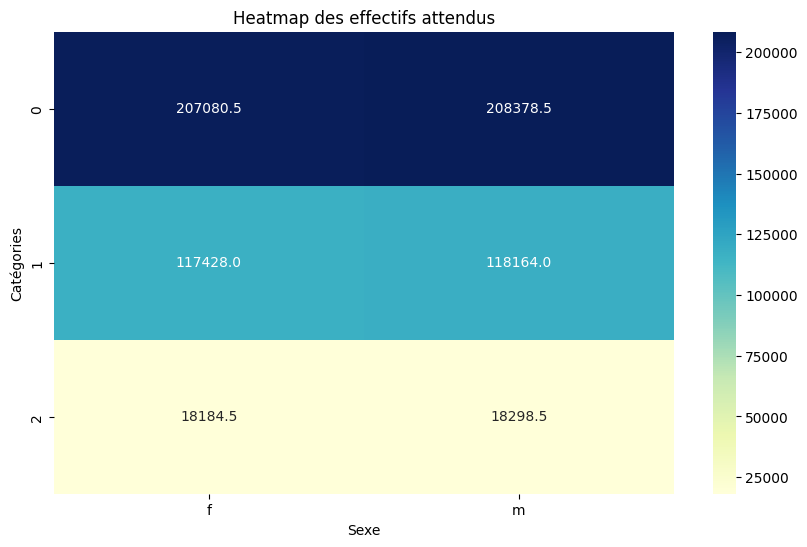

In [ ]:
# Convertir la table des effectifs attendus en DataFrame
expected_df = pd.DataFrame(expected, index=table.index, columns=table.columns)
# Transposer le DataFrame pour inverser les axes
expected_df_transposed = expected_df.T

# Afficher la heatmap avec les axes pivotés
plt.figure(figsize=(10, 6))
sns.heatmap(expected_df_transposed, annot=True, cmap="YlGnBu", fmt=".1f", cbar=True)

# Mettre à jour les labels en conséquence
plt.title("Heatmap des effectifs attendus")
plt.xlabel("Sexe")  
plt.ylabel("Catégories")
plt.show()

#test qualitatif 

## Correlation en prix et sexe<a id='53'></a>

        Statistique de Kruskal-Wallis : Cette statistique indique le degré de différence entre les groupes. Elle n'a pas une signification intuitive directement mais est utilisée pour déterminer la p-value.
    p-value : Comme pour le test t, la p-value est utilisée pour décider si les différences entre les groupes sont statistiquement significatives.
        Si p-value < 0.05 (ou tout autre seuil choisi, comme 0.01), alors tu peux rejeter l'hypothèse nulle, ce qui signifie qu'il y a une différence statistiquement significative entre les prix des groupes m et f.
        Si p-value > 0.05, cela signifie qu’il n’y a pas de différence significative entre les groupes au niveau de signification choisi.

Points à noter

    Test non paramétrique : Le test de Kruskal-Wallis ne repose pas sur l’hypothèse de normalité, mais il suppose que les distributions des deux groupes sont de forme similaire (distribution identique, sauf pour leur emplacement central, i.e., la médiane).
    Nombre de groupes : Le test de Kruskal-Wallis est généralement utilisé pour plus de deux groupes. Dans le cas de seulement deux groupes (m et f), il donne les mêmes résultats qu'un test de Mann-Whitney U (une autre alternative non paramétrique au test t pour deux échantillons).

In [ ]:
# Extraire les prix pour chaque groupe
prix_hommes = df[df['sex'] == 'm']['price'].dropna()
prix_femmes = df[df['sex'] == 'f']['price'].dropna()

# Appliquer le test de Kruskal-Wallis
stat, p_value = kruskal(prix_hommes, prix_femmes)

print(f"Statistique de Kruskal-Wallis : {stat}")
print(f"p-value : {p_value}")


Statistique de Kruskal-Wallis : 0.631628303965325
p-value : 0.42675866970199317


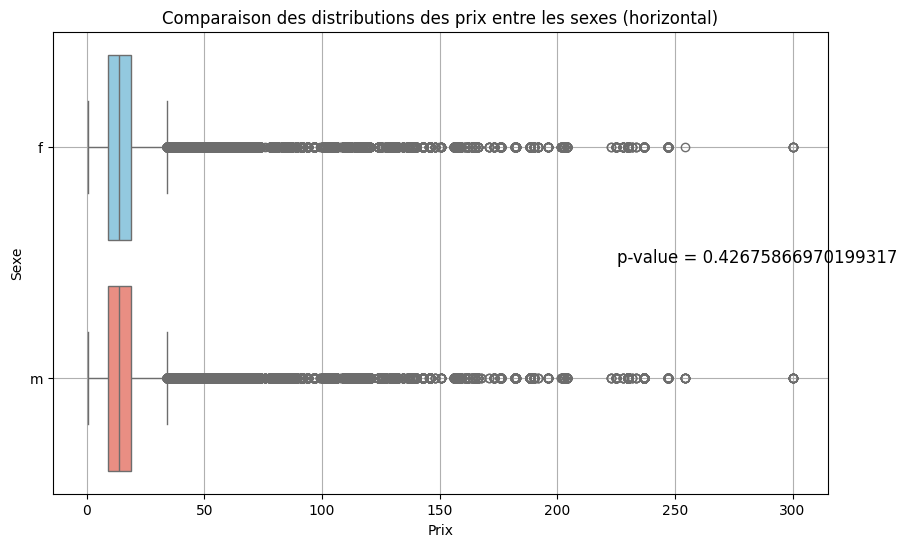

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='sex', x='price',hue='sex', palette=['skyblue', 'salmon'])

# Afficher la p-value sur le graphique
plt.text(max(df['price']) * 0.95, 0.5, f'p-value = {p_value}', ha='center', fontsize=12)

# Labels et titre
plt.ylabel("Sexe")
plt.xlabel("Prix")
plt.title("Comparaison des distributions des prix entre les sexes (horizontal)")
plt.grid()
plt.show()

#test mixte

In [ ]:
# Filtrer les données sans valeurs manquantes
group_H = df[df['sex'] == 'm']['price'].dropna()
group_F = df[df['sex'] == 'f']['price'].dropna()

# Vérifier que les deux groupes contiennent des données et que leurs variances sont non nulles
if len(group_H) > 0 and len(group_F) > 0:
    if group_H.var() > 0 and group_F.var() > 0:
        stat, p_value = ttest_ind(group_H, group_F)
        print(f"stat : {stat}", f"\n\np_value : {p_value}")
    else:
        print("Un des groupes a une variance nulle ; le test t n'est pas applicable.")
else:
    print("Un des groupes ne contient aucune donnée après le filtrage.")
    


stat : 5.845567273542113 

p_value : 5.050716395879035e-09


## Tests de spearman et correlation entre prix et âge<a id='54'></a>

In [ ]:
stat, p_value = spearmanr(df['price'], df['age'])
print(f"Statistique du test : {stat}",f"\np_value : {p_value}")

Statistique du test : -0.055464894621283005 
p_value : 0.0


## correslation en prix et âge

Coefficient de Spearman : stat=−0.055stat=−0.055

    Le coefficient de Spearman, ici, est proche de zéro et négatif. Un coefficient de Spearman près de zéro indique peu ou pas de corrélation monotone entre les variables age et price.
    La valeur -0.055 suggère une très légère tendance inverse (plus l'âge augmente, plus le prix pourrait baisser), mais cette relation est si faible qu’elle est probablement insignifiante.

Valeur-p = 0 :

    Ici, vous indiquez que la valeur-p est extrêmement faible (proche de zéro). Cela signifie que le résultat du test est statistiquement significatif, ce qui rejette l'hypothèse nulle d'absence de corrélation.
    Toutefois, même si ce résultat est significatif, le faible coefficient de Spearman montre que cette corrélation, bien que significative, est très faible. La relation détectée est donc statistiquement certaine mais n’a que peu de poids pratique (ou de force) dans les données.

-0.055464894621283005 0.0


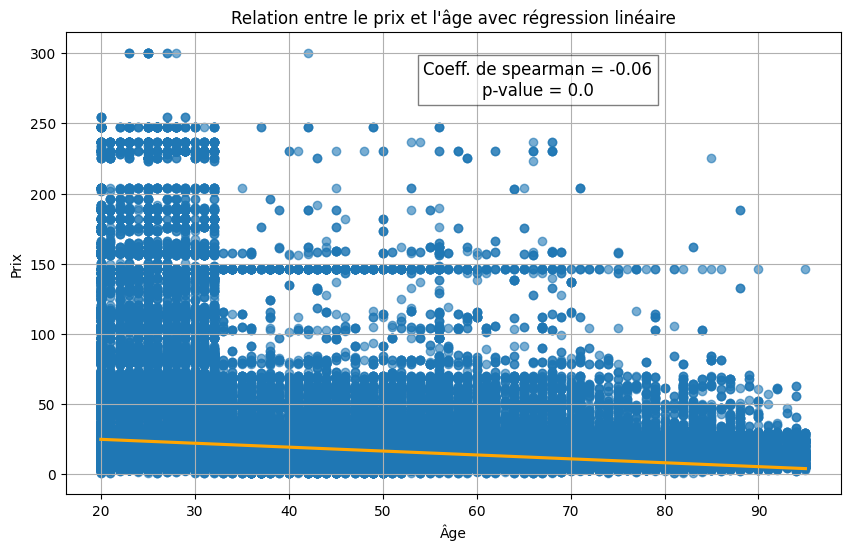

In [ ]:

# Calcul de la corrélation et de la p-value
stat, p_value = spearmanr(df['price'], df['age'])
print(stat,p_value)

# Créer le nuage de points avec la régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x='age', y='price', data=df, scatter_kws={'alpha':0.6}, line_kws={'color':'orange'})

# Ajouter les informations de corrélation sur le graphique
plt.text(max(df['age']) * 0.7, max(df['price']) * 0.9, f'Coeff. de spearman = {stat:.2f}\np-value = {p_value}', 
         ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Ajouter des labels et un titre
plt.xlabel("Âge")
plt.ylabel("Prix")
plt.title("Relation entre le prix et l'âge avec régression linéaire")
plt.grid()
plt.show()

#test quantitatif

## Comparaison de distribution entre sexe et prix<a id='55'></a>

In [ ]:

# Test Mann-Whitney pour des prix de deux groupes
stat, p_value = mannwhitneyu(df[df['sex'] == 'm']['price'], df[df['sex'] == 'f']['price'])
print(f"Statistique du test : {stat}",f"\np_value : {p_value}")


Statistique du test : 59021909940.0 
p_value : 0.42675867331671635


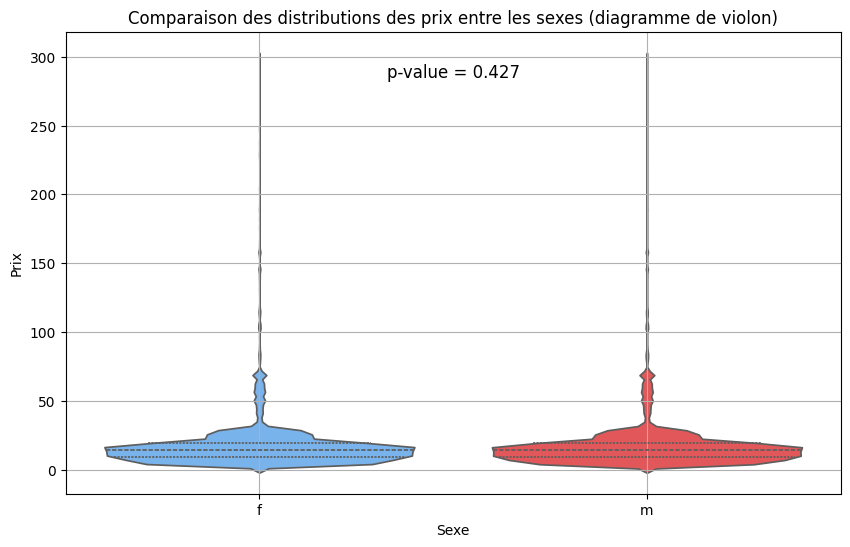

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='sex', y='price', inner="quartile",hue='sex' ,palette=['#66b3ff','#f94144'])

# Afficher la p_value sur le graphique
plt.text(0.5, max(df['price']) * 0.95, f'p-value = {p_value:.3f}', ha='center', fontsize=12)

# Ajouter des labels et un titre
plt.xlabel("Sexe")
plt.ylabel("Prix")
plt.title("Comparaison des distributions des prix entre les sexes (diagramme de violon)")
plt.grid()
plt.show()

#test mixte


avec une p-value de 0.426, on ne rejette pas l'hypothèse nulle, ce qui indique qu’il n’y a pas de différence significative entre les groupes.

La p-value (ou valeur p) est un concept clé dans les tests statistiques. Elle sert à évaluer la plausibilité des résultats obtenus sous l’hypothèse nulle (c’est-à-dire, l’hypothèse de non-effet ou d’absence de différence). Voici une explication plus détaillée de ce qu'elle représente et comment l'interpréter :
1. Définition de la p-value

La p-value est la probabilité d'obtenir des résultats aussi extrêmes ou plus extrêmes que ceux observés, en supposant que l'hypothèse nulle soit vraie.

En d’autres termes, elle mesure la probabilité que les différences ou les associations observées dans les données soient dues au hasard. Plus cette probabilité est faible, plus il est improbable que les résultats observés soient dus à la simple chance.
2. Interprétation de la p-value

    p-value faible (par exemple, < 0.05) : On considère généralement que les résultats sont statistiquement significatifs. Cela signifie qu'il est peu probable que les résultats soient dus au hasard, et on peut donc rejeter l'hypothèse nulle. En rejetant l'hypothèse nulle, on accepte l'idée qu'il y a une différence significative ou une relation significative entre les variables testées.

    p-value élevée (par exemple, ≥ 0.05) : Cela indique qu’il n’y a pas de preuve suffisante pour rejeter l’hypothèse nulle. Les résultats observés pourraient être dus au hasard, et on n'observe pas d'effet statistiquement significatif.


4. Attention aux interprétations

La p-value ne mesure pas la taille de l'effet ni l'importance pratique des résultats. Elle indique seulement s'il est probable que les résultats soient dus au hasard.

En résumé :

    Une p-value faible (souvent < 0.05) signifie que les résultats sont statistiquement significatifs, ce qui permet de rejeter l’hypothèse nulle.
    Une p-value élevée indique qu'il n'y a pas assez de preuves pour rejeter l'hypothèse nulle.

Enfin, bien que 0.05 soit un seuil commun, le choix du seuil dépend du contexte et des standards de l'étude.

## Distribution des âges par catégorie<a id='56'></a>

In [ ]:
df = df.dropna(how='all')

# Extraire les âges pour chaque groupe de catégorie
age_categ0 = df[df['categ'] == 0]['age'].dropna()
age_categ1 = df[df['categ'] == 1]['age'].dropna()
age_categ2 = df[df['categ'] == 2]['age'].dropna()

# Vérifier la taille des groupes pour s'assurer qu'ils ne sont pas vides
print("Taille des groupes :")
print(f"Categorie 0 : {age_categ0.size}")
print(f"Categorie 1 : {age_categ1.size}")
print(f"Categorie 2 : {age_categ2.size}")

stat, p_value = kruskal(age_categ0, age_categ1, age_categ2)

print(f"Statistique de Kruskal-Wallis : {stat}")
print(f"p-value : {p_value}")


Taille des groupes :
Categorie 0 : 415459
Categorie 1 : 235592
Categorie 2 : 36483
Statistique de Kruskal-Wallis : 78458.43837285662
p-value : 0.0


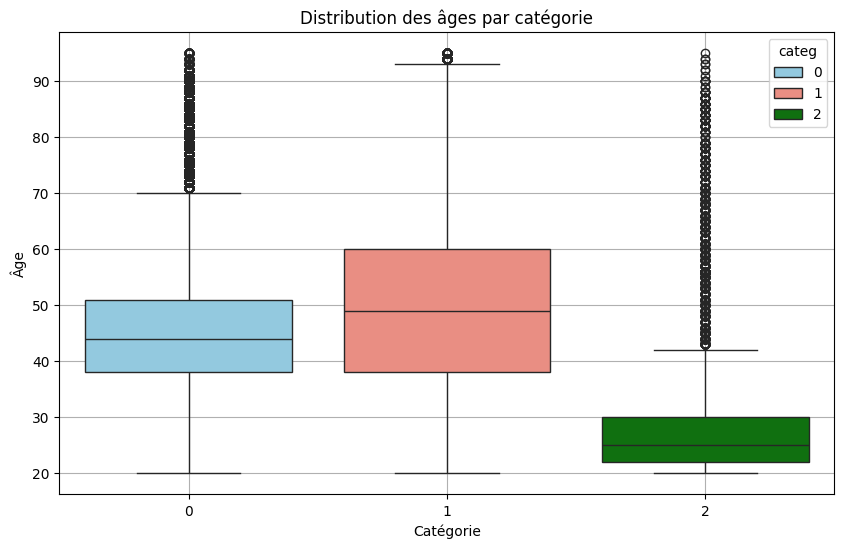

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='categ', y='age',hue='categ', data=df,palette=['skyblue', 'salmon','green'])

# Ajouter des titres et des labels
plt.title("Distribution des âges par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Âge")

# Afficher le graphique
plt.grid()
plt.show()

#test qualitatif

## Corrélation entre âge et panier moyen<a id='57'></a>

In [ ]:

# 1. Corrélation de Spearman entre âge et panier moyen
correlation, p_value = stats.spearmanr(panier['age'], panier['panier_moyen'])
print(f"Spearman correlation: {correlation}, p-value: {p_value}")

# 2. Comparaison par tranches d'âge (si besoin de groupes d'âge)
# Crée des groupes d'âge (par exemple jeunes < 30, adultes 30-50, seniors > 50)
panier['age_group'] = pd.cut(panier['age'], bins=[0, 30, 50, 100], labels=['Jeunes', 'Adultes', 'Seniors'])

# Test de Kruskal-Wallis pour comparer les groupes d'âge
kruskal_result = stats.kruskal(
    *[group['panier_moyen'].values for name, group in panier.groupby('age_group', observed=False)]
)
print(f"Kruskal-Wallis statistic: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}")


Spearman correlation: -0.7004372754541541, p-value: 0.0
Kruskal-Wallis statistic: 4442.530620382469, p-value: 0.0


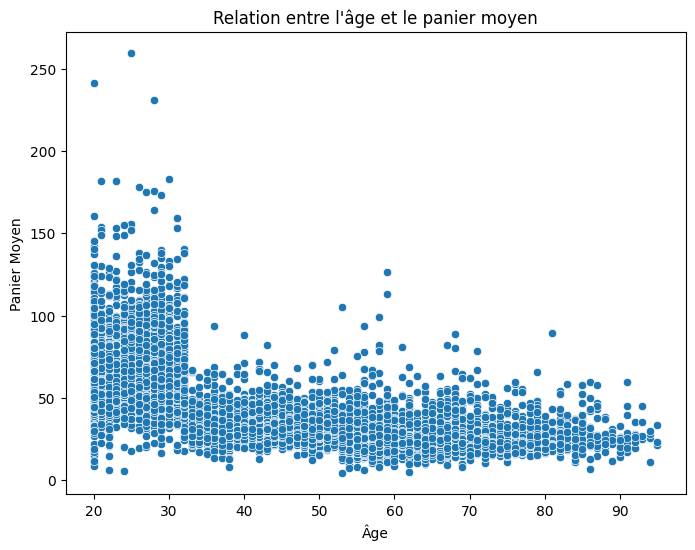

In [ ]:


plt.figure(figsize=(8, 6))
sns.scatterplot(data=panier, x='age', y='panier_moyen')
plt.title("Relation entre l'âge et le panier moyen")
plt.xlabel("Âge")
plt.ylabel("Panier Moyen")
plt.show()

#test quantitatif


## Fréquence d'achat par tranche d'âge<a id='58'></a>

In [ ]:
# Calcul de la fréquence d'achat (nombre de sessions) pour chaque client
df['date'] = pd.to_datetime(df['date'])  # Conversion de la colonne date en format datetime
frequence_achat = df.groupby('client_id')['session_id'].nunique().reset_index()
frequence_achat.columns = ['client_id', 'frequence_achat']

# Fusionner la fréquence d'achat avec les informations d'âge
data_merged = panier[['client_id', 'age']].drop_duplicates().merge(frequence_achat, on='client_id')

# Calcul de la corrélation de Spearman
correlation, p_value = spearmanr(data_merged['age'], data_merged['frequence_achat'])
print(f"\n Spearman correlation: {correlation}, p-value: {p_value}")


 Spearman correlation: 0.21176722196238146, p-value: 8.802387924159931e-88


In [ ]:
# Créer des groupes d'âge
data_merged['age_group'] = pd.cut(data_merged['age'], bins=[0, 30, 50, 100], labels=['Jeunes', 'Adultes', 'Seniors'])

# Test de Kruskal-Wallis pour comparer la fréquence d'achat par groupes d'âge
from scipy.stats import kruskal
kruskal_result = kruskal(
    *[group['frequence_achat'].values for name, group in data_merged.groupby('age_group', observed=False)]
)
print(f"\n Kruskal-Wallis statistic: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}")




 Kruskal-Wallis statistic: 1081.3485955281033, p-value: 1.5421832227015574e-235


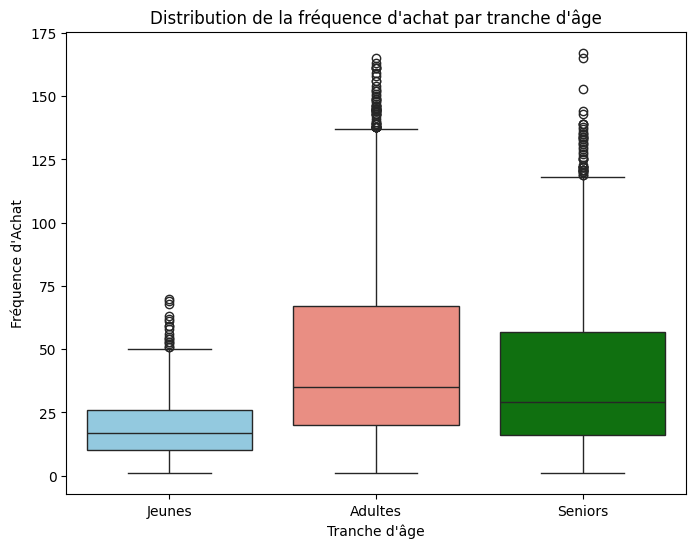

In [ ]:
ids_a_supprimer = [1609, 4958, 3454,6714 ] #liste des id des vendeurs pro

# on retire les id pro du dataframe car elle vont rendre les données illisible.
df_filtr = data_merged[~data_merged['client_id'].isin(ids_a_supprimer)]


#plotbox
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtr, x='age_group', y='frequence_achat',hue='age_group',palette=['skyblue', 'salmon','green'])
plt.title("Distribution de la fréquence d'achat par tranche d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Fréquence d'Achat")
plt.show()